<h1 style="color:DarkRed;">UBS Challenge 4ML: Model</h1>

In [51]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np

In [100]:
df = pd.read_csv("processed.csv")

We will start with a simple machine learning method and then advancing to more complex deep learning models makes sense for anomaly detection in an unsupervised setting. We'll begin with the Isolation Forest algorithm (does not require the data to have any specific distribution neither further assumprions).

- For the feature Selection: We'll use rate of change features such as "likes_per_content_weekly_change", "followers_weekly_change", and "comments_per_likes_weekly_change" as these reflect relative changes over time and are comparable across different entities.

In [104]:
features = [
    "likes_per_content_weekly_change", 
    "followers_weekly_change", 
    "comments_per_likes_weekly_change",
    "comments_per_likes_ma_2",
    "comments_per_likes_ma_3",
    "change_followers_ma_3",
    "comments_per_likes_ma_5",
    "change_followers_ma_5"
]


In [105]:
# We can assume no change
df['comments_per_likes_weekly_change'].replace([float('inf'), float('-inf')], 0, inplace=True)

### Autoencoder

In [106]:
# Let´s start with an Autoencoder

In [107]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),  
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, input_size),
            nn.Sigmoid(),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [108]:
features = [
    'likes_per_content_weekly_change',
    'followers_weekly_change',
    'comments_per_likes_weekly_change',
    'comments_per_likes_ma_2',
    'comments_per_likes_ma_3',
    'change_followers_ma_3',
    'comments_per_likes_ma_5',
    'change_followers_ma_5'
]

data_tensor = torch.tensor(df[features].values.astype(np.float32))

dataset = TensorDataset(data_tensor, data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [109]:
model = SimpleAutoencoder(input_size=len(features))
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-6)

num_epochs = 30

In [110]:
for epoch in range(num_epochs):
    model.train() 
    for inputs, _ in dataloader:
        inputs = inputs.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval() 
reconstruction_errors = []

for inputs, _ in dataloader:
    inputs = inputs.to(torch.float32)
    with torch.no_grad():
        outputs = model(inputs)
        sample_losses = ((inputs - outputs) ** 2).mean(dim=1)
        reconstruction_errors.extend(sample_losses.cpu().numpy())


reconstruction_errors = np.array(reconstruction_errors)


error_threshold = np.percentile(reconstruction_errors, 95)

anomalies_indices = np.where(reconstruction_errors > error_threshold)[0]

anomalies_autoencoder = df.iloc[anomalies_indices]

print(f'Anomalies detected: {len(anomalies_indices)}')


Epoch [1/30], Loss: 1062.4979
Epoch [2/30], Loss: 391.6302
Epoch [3/30], Loss: 33380.4727
Epoch [4/30], Loss: 172.7914
Epoch [5/30], Loss: 39.1574
Epoch [6/30], Loss: 113.0513
Epoch [7/30], Loss: 125.0594
Epoch [8/30], Loss: 119.8667
Epoch [9/30], Loss: 57.6614
Epoch [10/30], Loss: 52.2128
Epoch [11/30], Loss: 94.5225
Epoch [12/30], Loss: 87.0658
Epoch [13/30], Loss: 42.3503
Epoch [14/30], Loss: 79.3393
Epoch [15/30], Loss: 33.7385
Epoch [16/30], Loss: 202.4639
Epoch [17/30], Loss: 112.5570
Epoch [18/30], Loss: 218.2659
Epoch [19/30], Loss: 230.4335
Epoch [20/30], Loss: 165.4420
Epoch [21/30], Loss: 75.5942
Epoch [22/30], Loss: 196.3420
Epoch [23/30], Loss: 55.9137
Epoch [24/30], Loss: 365.0481
Epoch [25/30], Loss: 104.0735
Epoch [26/30], Loss: 2344.8318
Epoch [27/30], Loss: 147.2746
Epoch [28/30], Loss: 93.2190
Epoch [29/30], Loss: 56.0173
Epoch [30/30], Loss: 170.0302
Anomalies detected: 1515


The results does not look good in terms of converence. Probably the dataset is not the most suitable for this type of anomaly detection. However, let´s look which variables influenciate the most:

In [111]:
model.eval()
detailed_errors = []

for inputs, _ in dataloader:
    inputs = inputs.to(torch.float32)
    with torch.no_grad():
        outputs = model(inputs)
        
        batch_errors = (inputs - outputs) ** 2
        detailed_errors.append(batch_errors)


detailed_errors = torch.cat(detailed_errors, dim=0)

anomalies_data = []

for index in anomalies_indices:
    instance = df[features].iloc[index]
    error = detailed_errors[index] 
    
    high_error_features_indices = np.where(error > 0.95)[0] 
    high_error_features = df[features].columns[high_error_features_indices].tolist()
    
    anomalies_data.append(', '.join(high_error_features)
    )


anomalies_autoencoder["Relevant Features"] = anomalies_data


/var/folders/ff/76sw_qpn335gd_mh170rpmbm0000gn/T/ipykernel_58668/1667313243.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_autoencoder["Relevant Features"] = anomalies_data


In [112]:
anomalies_autoencoder["Relevant Features"]

23       likes_per_content_weekly_change, comments_per_...
29                        comments_per_likes_weekly_change
30       likes_per_content_weekly_change, comments_per_...
56       likes_per_content_weekly_change, comments_per_...
68       likes_per_content_weekly_change, comments_per_...
                               ...                        
30122    likes_per_content_weekly_change, comments_per_...
30147    likes_per_content_weekly_change, followers_wee...
30232    likes_per_content_weekly_change, comments_per_...
30244    likes_per_content_weekly_change, comments_per_...
30249    likes_per_content_weekly_change, comments_per_...
Name: Relevant Features, Length: 1515, dtype: object

In [113]:
# Let´s analyse the results:

all_features = ', '.join(anomalies_autoencoder['Relevant Features'])

feature_list = all_features.split(', ')

feature_counts = Counter(feature_list)

for feature, count in feature_counts.items():
    print(f"{feature}: {count}")


likes_per_content_weekly_change: 1368
comments_per_likes_weekly_change: 1401
followers_weekly_change: 65
change_followers_ma_3: 57
change_followers_ma_5: 57
: 23
comments_per_likes_ma_2: 3
comments_per_likes_ma_3: 2
comments_per_likes_ma_5: 1


#### We can see that comments_per_likes_weekly_change and likes_per_content_weekly_change where the ones that possible "generated" the anomalies


After some empirical validation of the results, we can see (again) that autoencoder is not the best choice. Let´s try something simpler

In [114]:
# Feature scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [115]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(df_scaled)

IsolationForest(contamination=0.01, random_state=42)

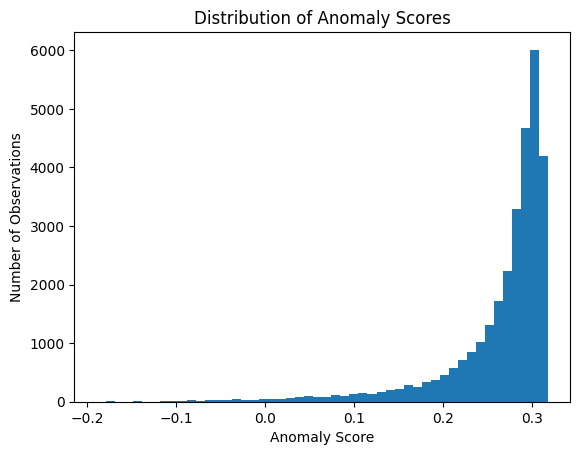

In [116]:
df['anomaly_iso_forest'] = iso_forest.predict(df_scaled)
df['anomaly_score'] = iso_forest.decision_function(df_scaled)

plt.hist(df['anomaly_score'], bins=50)
plt.xlabel('Anomaly Score')
plt.ylabel('Number of Observations')
plt.title('Distribution of Anomaly Scores')
plt.show()

The x-axis indicates the range of anomaly scores. Scores close to 0 indicate less anomalous data points, while those moving away from 0 (towards -0.2 and 0.3) indicate more anomalous data points.

In [117]:
anomalies_iso_forest = df[df['anomaly_iso_forest'] == -1]

In [118]:
anomalies_iso_forest

,Unnamed: 0,legal_entity,date,followers,pictures,videos,comments,likes,close,content,...,change_followers_ma_2,Close_price_weekly_change_ma_2,comments_per_likes_ma_3,change_followers_ma_3,Close_price_weekly_change_ma_3,comments_per_likes_ma_5,change_followers_ma_5,Close_price_weekly_change_ma_5,anomaly_iso_forest,anomaly_score
12,12,AbbVie,2021-11-20,9187.0,4.0,0.0,0.0,228.0,107.903076,4.0,...,5.553877,1.120340,0.000000,4.577813,0.538866,0.000000,3.864647,0.725255,-1,-0.002253
1949,1949,Beiersdorf,2016-07-23,9168.0,9.0,1.0,76.0,4030.0,77.994331,10.0,...,6.069415,-0.910379,0.022538,5.825835,-0.535544,0.025072,6.140940,-0.439669,-1,-0.010010
1950,1950,Beiersdorf,2016-07-30,9917.0,10.0,2.0,109.0,5116.0,79.965179,12.0,...,7.374793,0.501464,0.020999,6.769517,0.235385,0.023310,6.478969,0.082272,-1,-0.016080
1951,1951,Beiersdorf,2016-08-06,10677.0,9.0,1.0,93.0,4441.0,79.220207,10.0,...,7.916664,0.797646,0.020368,7.471065,0.023769,0.021972,6.662167,-0.002268,-1,-0.011292
1952,1952,Beiersdorf,2016-08-13,11167.0,6.0,2.0,84.0,3883.0,79.342796,8.0,...,6.126456,-0.388438,0.021293,6.807544,0.583345,0.021114,6.512292,-0.014144,-1,-0.005920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30284,30284,iRobot Corp,2023-08-12,307626.0,90.0,58.0,3994.0,2264.0,39.110001,148.0,...,0.009430,1.887084,1.842369,0.011381,0.131296,1.782597,0.016654,-3.493341,-1,-0.057105
30285,30285,iRobot Corp,2023-08-19,307679.0,90.0,59.0,2989.0,2124.0,38.770000,149.0,...,0.023409,2.459566,1.662296,0.012030,0.968275,1.781647,0.018928,-0.347936,-1,-0.070575
30286,30286,iRobot Corp,2023-08-26,307842.0,96.0,74.0,3092.0,2903.0,36.340000,170.0,...,0.035103,-3.568538,1.412163,0.033265,-0.449534,1.599893,0.020870,-1.348638,-1,-0.064426
30287,30287,iRobot Corp,2023-09-02,307980.0,94.0,71.0,3038.0,2574.0,35.099998,165.0,...,0.048903,-4.839978,1.217540,0.038345,-3.516433,1.446451,0.026779,-1.355026,-1,-0.059263


Let´s see if, according to this model, the anomalies have some implications on the financial results of the underlying stock

For us, is important to understand why the model decides when an observation is an anomally or not. Let´s do some statistical analysis (assuming the data is normally distributed), computing confidence intervals and assuming that, when a column is outside the confidence interval, could be one of the reasons why the model decided the observation was classified as an anomaly:

In [119]:
for index, anomaly in anomalies_iso_forest.iloc[:3,:].iterrows():
    print(f"Anomaly at index {index}:")
    for feature in features:
        value = anomaly[feature]
        typical_range = (df[feature].mean() - 2 * df[feature].std(), df[feature].mean() + 2 * df[feature].std())
        if not (typical_range[0] <= value <= typical_range[1]):
            print(f"Feature {feature} with value {value} is outside the typical range of {typical_range}.")
            
    print("\n")


Anomaly at index 12:
Feature followers_weekly_change with value 6.90016290435187 is outside the typical range of (-1.8395283385556915, 2.706959280882657).
Feature change_followers_ma_3 with value 4.577812654493877 is outside the typical range of (-1.3006478511772894, 2.178664210512727).
Feature change_followers_ma_5 with value 3.864647184445529 is outside the typical range of (-1.205327433146739, 2.0934304515462863).


Anomaly at index 1949:
Feature followers_weekly_change with value 6.579865147640085 is outside the typical range of (-1.8395283385556915, 2.706959280882657).
Feature change_followers_ma_3 with value 5.82583525208263 is outside the typical range of (-1.3006478511772894, 2.178664210512727).
Feature change_followers_ma_5 with value 6.140940460982898 is outside the typical range of (-1.205327433146739, 2.0934304515462863).


Anomaly at index 1950:
Feature followers_weekly_change with value 8.169720767888311 is outside the typical range of (-1.8395283385556915, 2.706959280882

In [120]:
# Now, let´s define a function to store this results:

In [121]:
def find_outliers(row, features, df):
    outlier_features = []
    for feature in features:
        value = row[feature]
        typical_range = (df[feature].mean() - 2 * df[feature].std(), df[feature].mean() + 2 * df[feature].std())
        if not (typical_range[0] <= value <= typical_range[1]):
            outlier_features.append(feature)
    return ', '.join(outlier_features)

anomalies_iso_forest['outlier_features'] = anomalies_iso_forest.apply(find_outliers, axis=1, features=features, df=df)


/var/folders/ff/76sw_qpn335gd_mh170rpmbm0000gn/T/ipykernel_58668/621519143.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_iso_forest['outlier_features'] = anomalies_iso_forest.apply(find_outliers, axis=1, features=features, df=df)


In [122]:
# Let´s look to an example
anomalies_iso_forest.loc[12,'outlier_features']

'followers_weekly_change, change_followers_ma_3, change_followers_ma_5'

Let´s make an analysis of how those variables impact on the decisions and let´s use the findings into a investing strategy

In [123]:

all_features = ', '.join(anomalies_iso_forest['outlier_features'])

feature_list = all_features.split(', ')

feature_counts = Counter(feature_list)

for feature, count in feature_counts.items():
    print(f"{feature}: {count}")


followers_weekly_change: 86
change_followers_ma_3: 96
change_followers_ma_5: 94
comments_per_likes_ma_2: 220
comments_per_likes_ma_3: 218
comments_per_likes_ma_5: 210
comments_per_likes_weekly_change: 41
likes_per_content_weekly_change: 9
: 2


It is interesting to see that the MA comments per likes are the most important ones. Also, followers_weekly_change keeps its importance



Now, let´s transform this insights into value. What would we expect?

- If followers decreases significantly: probably a "scandal" happened on the company, thus the stock price will go down. 
- If comments_per_likes_weekly_change goes up: We assume that could be due to "negative" comments. We would expect the stock going down. An increase, may suggest a possitive engagment, but probably it will not be reflected on our financial data application.
- If likes_per_content_weekly_change goes up: Increased engagement may indicate positive reception or interest in the company's activities, possibly a bullish signal for the stock. The opposite interpretation is analogous.
- If followers increases significantly: goes up
- comments_per_likes_ma_2, comments_per_likes_ma_3, comments_per_likes_ma_5 (Moving Averages Going Up/Down): Up: Consistently higher engagement over time may signal sustained interest or ongoing issues attracting attention. Down: Consistently lower engagement may indicate a trend of decreasing visibility or fading interest.
- change_followers_ma_3, change_followers_ma_5 (Moving Averages Going Up/Down): Up: An upward trend in follower count could be a sign of growing popularity or successful marketing campaigns. Down: A downward trend might suggest a loss of consumer confidence or interest, potentially affecting the company's future revenue.


In [124]:
anomalies_iso_forest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 12 to 30288
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        303 non-null    int64  
 1   legal_entity                      303 non-null    object 
 2   date                              303 non-null    object 
 3   followers                         303 non-null    float64
 4   pictures                          303 non-null    float64
 5   videos                            303 non-null    float64
 6   comments                          303 non-null    float64
 7   likes                             303 non-null    float64
 8   close                             303 non-null    float64
 9   content                           303 non-null    float64
 10  likes_per_content                 303 non-null    float64
 11  comments_per_likes                303 non-null    float64
 12  likes_per_

### Let´s use these insights in designing our strategy for financial advice. 

In [125]:
anomalies_iso_forest["action"] = "Hold"
# We define some "priorities" in our strategy:
for index, row in anomalies_iso_forest.iterrows():
    if "followers_weekly_change" in row["outlier_features"]:
        if row["followers_weekly_change"] < 0:
            anomalies_iso_forest.at[index, "action"] = "Sell"
            continue

    if "comments_per_likes_weekly_change" in row["outlier_features"]:
        if row["comments_per_likes_weekly_change"] > 0:
            anomalies_iso_forest.at[index, "action"] = "Sell"
                        


/var/folders/ff/76sw_qpn335gd_mh170rpmbm0000gn/T/ipykernel_58668/1336223644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_iso_forest["action"] = "Hold"


In [126]:
# Let´s compare the results against the real values:

anomalies_iso_forest["action"].unique()  # We can take the "Hold"s out
anomalies_iso_forest = anomalies_iso_forest[(anomalies_iso_forest["action"] != "Hold")]


In [127]:
for index, row in anomalies_iso_forest.iterrows():

    anomalies_iso_forest.at[index, "results"] = 0

    if row['action'] == 'Sell' and row['Close_price_weekly_change'] < 0:
        anomalies_iso_forest.at[index, "results"] = 1

    # If the action was 'Buy' and the close price increased
    elif row['action'] == 'Buy' and row['Close_price_weekly_change'] > 0:
        anomalies_iso_forest.at[index, "results"] = 1

/var/folders/ff/76sw_qpn335gd_mh170rpmbm0000gn/T/ipykernel_58668/226384090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_iso_forest.at[index, "results"] = 0


In [128]:
anomalies_iso_forest[["results", "Close_price_weekly_change",
                      "likes_per_content_weekly_change", 
    "followers_weekly_change", 
    "comments_per_likes_weekly_change",
    "comments_per_likes_ma_2",
    "comments_per_likes_ma_3",
    "change_followers_ma_3",
    "comments_per_likes_ma_5",
    "change_followers_ma_5" ]]

,results,Close_price_weekly_change,likes_per_content_weekly_change,followers_weekly_change,comments_per_likes_weekly_change,comments_per_likes_ma_2,comments_per_likes_ma_3,change_followers_ma_3,comments_per_likes_ma_5,change_followers_ma_5
3486,1.0,-4.550362,7.913884,14.068905,386.704955,0.034292,0.026853,19.531253,0.020781,11.633047
4471,0.0,9.815949,59.653652,1.315837,8718.097702,0.673743,0.454702,0.729237,0.280041,0.612228
4506,1.0,-10.129867,70.618000,0.755287,3840.194944,0.368968,0.250997,0.403161,0.156973,0.306951
5086,1.0,-0.348257,29.299061,1.975194,967.225196,0.972139,0.716488,0.900578,0.582225,0.808305
5138,1.0,-0.782856,80.740575,2.879046,1473.482893,2.200034,1.571258,1.122527,1.064045,0.998782
5563,1.0,-1.771490,21.034781,-0.182895,420.476252,0.338153,0.266909,-0.141656,0.215042,-0.146723
5620,1.0,-0.733249,24.444444,0.654493,3892.063492,1.918155,1.314064,0.419770,0.826091,0.350593
5669,1.0,-0.053061,193.650794,3.110599,2836.636637,1.346292,0.926537,1.275760,0.591305,1.017141
5674,1.0,-10.011134,39.925023,3.062141,3835.521700,1.673588,1.683071,1.513768,1.808480,1.603696
5680,0.0,11.171447,0.273018,1.062151,807.819365,0.343941,0.250225,1.319896,0.956857,0.988905


In [129]:
sum(anomalies_iso_forest["results"])/len(anomalies_iso_forest)

0.6097560975609756

We find an accuracy of nearly 61% in the strategy. Limitations of the strategy include the timespan convered by the dataset, not taking into account comisions, and not evaluating the total profit.

The goal of the strategy is to be able to advice that with a high probability the stock price will decrease on the next day. One advantage of the model is that, as it relies on unsupervised learning and knowledge of the industry, the strategy is less likely to be overfitting.